# Train Models
<div style="color:red; font-size:14px;">!! Don't define functions here, import them from utils.py</div>

This notebook contains the code needed to train and store models to disk.

Remember that if you use a function with a random state you have to fix it to a number so that the results are reproducible.

## Imports

In [1]:
# Install livelossplot
!pip install livelossplot

In [2]:
# Cython import
!python skseq/setup.py build_ext --build-lib=./skseq

running build_ext


In [5]:
import pandas as pd
import pickle

from skseq.id_feature import IDFeatures
from skseq.extended_feature import ExtendedFeatures

from skseq import structured_perceptron_c 
from skseq.structured_perceptron import StructuredPerceptron

from utils.utils import *

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback


In [6]:
%load_ext autoreload
%autoreload 2

## Create Train set

In [7]:
train = pd.read_csv("data/train_data_ner.csv")

In [8]:
X_train, y_train = get_data_target_sets(train)

Processing: 100%|██████████| 38366/38366 [02:15<00:00, 283.78sentence/s]


### Create Corpus

We need to create our corpus using the training data. The corpus consists of two dictionaries, one for the words and one for the tags. The words dictionary maps each word to an index and the tags dictionary maps each tag to an index. We also need to create the reverse mapping for the tags dictionary. This is needed to convert the predictions back to the tag names.

Example:
```python
        sentences = [['I', 'love', 'Python'], ['Python', 'is', 'great']]
        tags = ['O', 'O', 'B']
        word_dict, tag_dict, tag_dict_rev = create_corpus(sentences, tags)
        # word_dict: {'I': 0, 'love': 1, 'Python': 2, 'is': 3, 'great': 4}
        # tag_dict: {'O': 0, 'B': 1}
        # tag_dict_rev: {0: 'O', 1: 'B'}
```

In [9]:
word_dict, tag_dict, tag_dict_rev = create_corpus(X_train, y_train)

### Create Training Sequence List

#### No Cython

In [10]:
train_seq = create_sequence_list(word_dict, tag_dict, X_train, y_train)

Adding sequences: 100%|██████████| 38366/38366 [13:01<00:00, 49.08sequence/s]


#### Cython

In [11]:
train_seq = create_sequence_listC(word_dict, tag_dict, X_train, y_train)

Adding sequences: 100%|██████████| 38366/38366 [11:10<00:00, 57.24sequence/s]


Notice a time improvement of around 2 minutes using Cython!

In [8]:
print(train_seq[0])
print(train_seq[0].to_words(sequence_list=train_seq))

0/0 1/0 2/0 3/0 4/0 5/0 6/1 7/0 8/0 9/0 10/0 11/0 12/1 13/0 14/0 9/0 15/0 1/0 16/2 17/0 18/0 19/0 20/0 21/0 
Thousands/O of/O demonstrators/O have/O marched/O through/O London/B-geo to/O protest/O the/O war/O in/O Iraq/B-geo and/O demand/O the/O withdrawal/O of/O British/B-gpe troops/O from/O that/O country/O ./O 


## Train Models

<div class="alert" style="padding: 20px;background-color: #2cbc84; color: white; margin-bottom: 15px;">
<h3>Structured Perceptron w/ Default Features</h3>
</div>

To train the structured perceptron we must create a feature mapper and build it.

In [9]:
feature_mapper = IDFeatures(train_seq)
feature_mapper.build_features()

In [10]:
show_features(feature_mapper, train_seq[0])

Initial features
[0] init_tag:O


Transition features
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[9] prev_tag:O::B-geo
[11] prev_tag:B-geo::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[9] prev_tag:O::B-geo
[11] prev_tag:B-geo::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[21] prev_tag:O::B-gpe
[23] prev_tag:B-gpe::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O


Final features
[28] final_prev_tag:O


Emission features
[1] id:Thousands::O
[2] id:of::O
[4] id:demonstrators::O
[5] id:have::O
[6] id:marched::O
[7] id:through::O
[8] id:London::B-geo
[10] id:to::O
[12] id:protest::O
[13] id:the::O
[14] id:war::O
[15] id:in::O
[16] id:Iraq::B-geo
[17] id:and::O
[18] id:demand::O
[13] id:the::O
[19] id:withdrawal::O
[2] id:of::O
[20] id:British::B-gpe
[22] id:troops::O
[24] id:from::O
[25] id:that::O
[26] id:country::O
[27] id:.::O




### Train

#### No Cython

In [10]:
num_epochs = 15
sp = StructuredPerceptron(word_dict, tag_dict, feature_mapper)
sp.num_epochs = 5

In [11]:
%%time
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.893815
Epoch: 1 Accuracy: 0.931674
Epoch: 2 Accuracy: 0.940913
Epoch: 3 Accuracy: 0.946175
Epoch: 4 Accuracy: 0.950018
Epoch: 5 Accuracy: 0.952577
Epoch: 6 Accuracy: 0.954425
Epoch: 7 Accuracy: 0.956033
Epoch: 8 Accuracy: 0.957185
Epoch: 9 Accuracy: 0.958481
Epoch: 10 Accuracy: 0.959217
Epoch: 11 Accuracy: 0.960524
Epoch: 12 Accuracy: 0.961121
Epoch: 13 Accuracy: 0.961207
Epoch: 14 Accuracy: 0.961983
CPU times: user 1h 33min 59s, sys: 20 s, total: 1h 34min 19s
Wall time: 1h 34min 18s


#### Cython

In [11]:
num_epochs = 15
sp_c = structured_perceptron_c.StructuredPerceptronC(word_dict, tag_dict, feature_mapper)
sp_c.num_epochs = 5

In [12]:
%%time
sp_c.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.893815
Epoch: 1 Accuracy: 0.931674
Epoch: 2 Accuracy: 0.940913
Epoch: 3 Accuracy: 0.946175
Epoch: 4 Accuracy: 0.950018
Epoch: 5 Accuracy: 0.952577
Epoch: 6 Accuracy: 0.954425
Epoch: 7 Accuracy: 0.956033
Epoch: 8 Accuracy: 0.957185
Epoch: 9 Accuracy: 0.958481
Epoch: 10 Accuracy: 0.959217
Epoch: 11 Accuracy: 0.960524
Epoch: 12 Accuracy: 0.961121
Epoch: 13 Accuracy: 0.961207
Epoch: 14 Accuracy: 0.961983
CPU times: user 59min 8s, sys: 13.5 s, total: 59min 21s
Wall time: 59min 20s


### Save

In [13]:
sp.save_model("fitted_models/01_SP_Default_Features")
sp_c.save_model("fitted_models/01C_SP_Default_Features")

<div class="alert" style="padding: 20px;background-color: #2cbc84; color: white; margin-bottom: 15px;">
<h3>Structured Perceptron w/ New Features</h3>
</div>

In [12]:
feature_mapper_ext = ExtendedFeatures(train_seq)
feature_mapper_ext.build_features()

In [13]:
show_features(feature_mapper_ext, train_seq[1])

Initial features
[0] init_tag:O


Transition features
[8] prev_tag:O::O
[45] prev_tag:O::B-tim
[47] prev_tag:B-tim::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[16] prev_tag:O::B-geo
[18] prev_tag:B-geo::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[59] prev_tag:O::B-org
[61] prev_tag:B-org::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[16] prev_tag:O::B-geo
[77] prev_tag:B-geo::I-geo
[78] prev_tag:I-geo::O


Final features
[38] final_prev_tag:O


Emission features
[39, 2, 3] id:Helicopter::O
[39, 2, 3] firstupper::O
[39, 2, 3] alphanum::O
[40, 5, 3] id:gunships::O
[40, 5, 3] lower::O
[40, 5, 3] alphanum::O
[41, 42, 43, 44, 44] id:Saturday::B-tim
[41, 42, 43, 44, 44] firstupper::B-tim
[41, 42, 43, 44, 44] alphanum::B-tim
[41, 42, 43, 44, 44

### Train

#### No Cython

In [14]:
num_epochs = 15
sp_ext = StructuredPerceptron(word_dict, tag_dict, feature_mapper_ext)
sp_ext.num_epochs = 5

In [15]:
%%time
sp_ext.fit(feature_mapper_ext.dataset, num_epochs)

Epoch: 0 Accuracy: 0.930157
Epoch: 1 Accuracy: 0.944669
Epoch: 2 Accuracy: 0.948542
Epoch: 3 Accuracy: 0.951180
Epoch: 4 Accuracy: 0.953505
Epoch: 5 Accuracy: 0.954438
Epoch: 6 Accuracy: 0.955883
Epoch: 7 Accuracy: 0.956796
Epoch: 8 Accuracy: 0.957754
Epoch: 9 Accuracy: 0.958079
Epoch: 10 Accuracy: 0.959030
Epoch: 11 Accuracy: 0.959852
Epoch: 12 Accuracy: 0.959726
Epoch: 13 Accuracy: 0.960705
Epoch: 14 Accuracy: 0.961026
CPU times: total: 2h 3min 41s
Wall time: 2h 5min 59s


#### Cython

In [16]:
num_epochs = 15
sp_ext_c = structured_perceptron_c.StructuredPerceptronC(word_dict, tag_dict, feature_mapper_ext)
sp_ext_c.num_epochs = 5

In [17]:
%%time
sp_ext_c.fit(feature_mapper_ext.dataset, num_epochs)

Epoch: 0 Accuracy: 0.930157
Epoch: 1 Accuracy: 0.944669
Epoch: 2 Accuracy: 0.948542
Epoch: 3 Accuracy: 0.951180
Epoch: 4 Accuracy: 0.953505
Epoch: 5 Accuracy: 0.954438
Epoch: 6 Accuracy: 0.955883
Epoch: 7 Accuracy: 0.956796
Epoch: 8 Accuracy: 0.957754
Epoch: 9 Accuracy: 0.958079
Epoch: 10 Accuracy: 0.959030
Epoch: 11 Accuracy: 0.959852
Epoch: 12 Accuracy: 0.959726
Epoch: 13 Accuracy: 0.960705
Epoch: 14 Accuracy: 0.961026
CPU times: user 1h 40s, sys: 12.1 s, total: 1h 52s
Wall time: 1h 53s


### Save

In [26]:
sp_ext.save_model("fitted_models/02_SP_Extended_Features")
sp_ext_c.save_model("fitted_models/02C_SP_Extended_Features")

<div class="alert" style="padding: 20px;background-color: #2cbc84; color: white; margin-bottom: 15px;">
<h3>DL Approach. Bi-LSTM</h3>
</div>

### Download data

In [3]:
train = pd.read_csv("data/train_data_ner.csv")
test = pd.read_csv("data/test_data_ner.csv")

### Preprocess data

In [4]:
sentences_train, tags_train, num_words, num_tags, word2idx, tag2idx = preprocess_BiLSTM_train_data(train)

In [5]:
sentences_test, tags_test = preprocess_BiLSTM_test_data(test, word2idx, tag2idx,num_words)

### Create and Train model

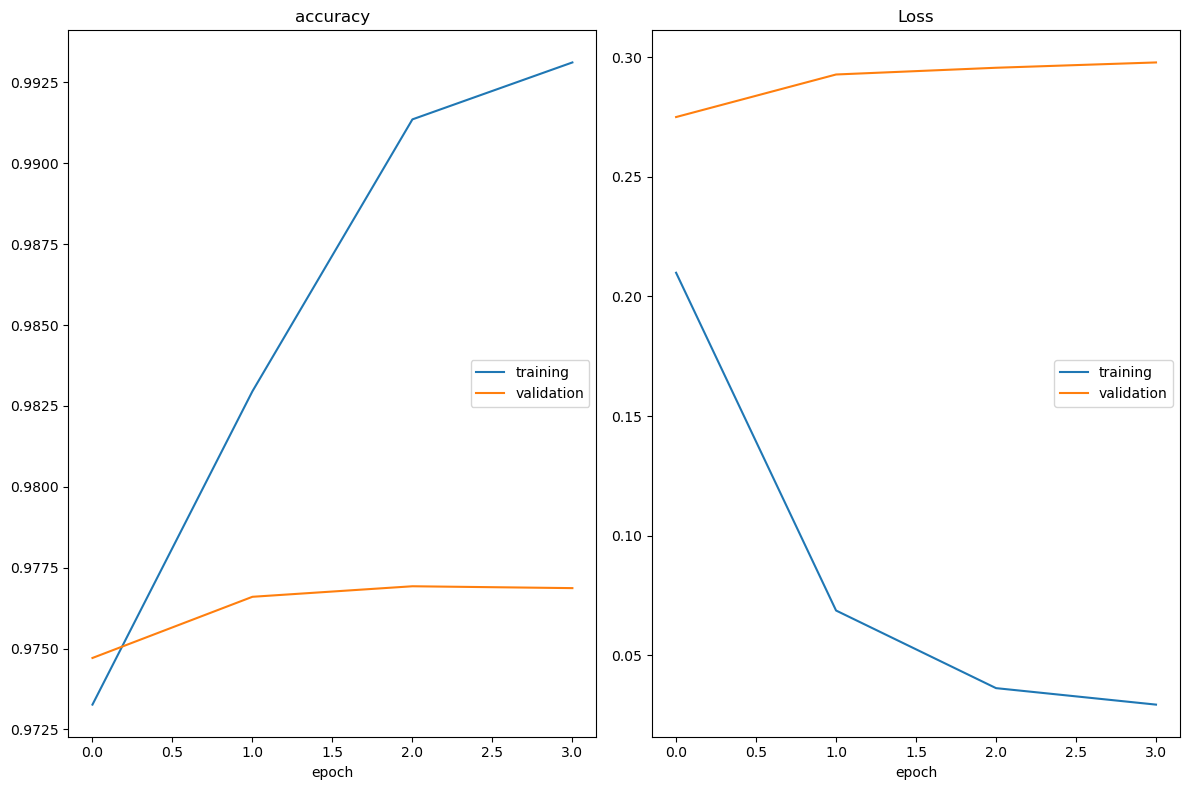

accuracy
	training         	 (min:    0.973, max:    0.993, cur:    0.993)
	validation       	 (min:    0.975, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.029, max:    0.210, cur:    0.029)
	validation       	 (min:    0.275, max:    0.298, cur:    0.298)

Epoch 4: val_loss did not improve from 0.27495
1199/1199 [==============================] - 224s 187ms/step - loss: 0.0295 - accuracy: 0.9931 - val_loss: 0.2978 - val_accuracy: 0.9769


Launching TensorBoard...

In [6]:
logdir = "log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# ModelCheckpoint callback to save the best model weights
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# EarlyStopping callback to stop training early if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

# Define a list of callbacks to be used during training
callbacks = [PlotLossesCallback(), chkpt, early_stopping, tensorboard_callback]

# Create the BiLSTM model
model = create_BiLSTM_model(num_words)

# Train the model
history = model.fit(
    x=sentences_train,
    y=tags_train,
    validation_data=(sentences_test, tags_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Load the TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard to visualize the logs
%tensorboard --logdir log

### Save model

In [7]:
model.save("fitted_models/03_BiLSTM.h5")